
## BUSINESS CASE | Satisfaction Surveys Analysis

### 🙌 Preparing the environment:

In [62]:
#Library for English sentiment analysis:
#!pip install vaderSentiment

#Library for Spanish sentiment analysis
#!pip install spanish_sentiment_analysis

from classifier import *
clf = SentimentClassifier()

In [63]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import csv

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### APPENDIX | Functions:

In [77]:
# TOKENIZING AND REMOVING STOPWORDS

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import unicodedata
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def clean_en_text(quote):
  words = quote.split()
  words = [word.lower() for word in words if (word.isalpha() and word not in en_stop_words and word != "\n" and word != "rt")]
  return (" ").join(words)

def clean_es_text(quote):
  words = quote.split()
  words = [word.lower() for word in words if (word.isalpha() and word not in es_stop_words and word != "\n" and word != "rt")]
  return (" ").join(words)


[nltk_data] Downloading package punkt to /home/irene/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/irene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
# ENGLISH SENTIMENT ANALYSIS with VADER:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))
  

# Getting only the negative score
def negative_score(text):
    negative_value = analyser.polarity_scores(text)['neg']
    return negative_value

# Getting only the neutral score
def neutral_score(text):
    neutral_value = analyser.polarity_scores(text)['neu']
    return neutral_value

# Getting only the positive score
def positive_score(text):
    positive_value = analyser.polarity_scores(text)['pos']
    return positive_value
   

# Assigning a value according to sentiment
def sentiment_classifier(text):
    """
    English sentiment model gives three diferent scores between 0 and 1, for negative, positive and neutral comments.
    We decided to compare "positive" and "negative" scores and, in case they were equal, then consider it as "neutral".
    """
    VADER_sent_en = []
    sentiment_scores = {"neg":0, "pos":1, "neu":2}
    for item in text:
        if negative_score(item) > positive_score(item):
            #print(negative_score(item), "is higher than ", positive_score(item), "NEUTRAL: ", neutral_score(item))
            VADER_sent_en.append(sentiment_scores["neg"])
        elif negative_score(item) < positive_score(item):
            #print(negative_score(item), "is lower than ", positive_score(item), "NEUTRAL: ", neutral_score(item))
            VADER_sent_en.append(sentiment_scores["pos"])
        else:
            VADER_sent_en.append(sentiment_scores["neu"])
    
    return VADER_sent_en


In [66]:
# SPANISH SENTIMENT ANALISYS with SENTY:

def senty_classifier_es(text):
    """
    Spanish sentiment model gives a score between 0 and 1, Being 0 the most "negative" score and 1 the most "positive" score.
    We decided to take all scores between 0.4 and 0.6 as to be "neutral".
    """
    SENTY_sent_es = []
    sentiment_scores = {"neg":0, "pos":1, "neu":2}
    max_neg_score = 0.4
    min_pos_score = 0.6
    for item in text:
        if type(item)!=float:
            if clf.predict(item) < max_neg_score:
                #print(round(clf.predict(item), 2), "is lower than ", max_neg_score)
                SENTY_sent_es.append(sentiment_scores["neg"])
                #print("Negative score", sentiment_scores["neg"], "appended.")
            elif clf.predict(item) > min_pos_score:
                #print(clf.predict(item), "is higher than ", min_pos_score)
                SENTY_sent_es.append(sentiment_scores["pos"])
                #print("Positive score", sentiment_scores["pos"], "appended.")
            else:
                #print(clf.predict(item), "is between ", max_neg_score, "and", min_pos_score)
                SENTY_sent_es.append(sentiment_scores["neu"])
                #print("Neutral score", sentiment_scores["neu"], "appended.")
        else:
            SENTY_sent_es.append(sentiment_scores["neu"])
    
    return SENTY_sent_es


In [67]:
# PLOTTING DISTRIBUTIONS

def distributionPlot(data, columnNumber):
    """ 
    Generates the distribution plot for the given data.
    Parameters:
        data: dataframe with the data to plot.
        columNumber: Number of columns the plot will return.
    """
    data_columns = data.columns.values
    #data_columns = data._get_numeric_data().columns.values
    plot_columns = columnNumber
    number_of_columns = math.ceil(len(data_columns)/plot_columns)
    number_of_rows = math.ceil((len(data_columns))/number_of_columns)

    plt.figure(figsize=(16,22))

    # plot distribution
    for i in range(0, len(data_columns)):
        plt.subplot(number_of_columns + 1, number_of_rows, i+1)
        sns.distplot(data[data_columns[i]], kde=True) 

In [68]:
# PLOTTING BOXES:

def boxplot_conf(data, columnNumber):
    """ 
    Generates the boxplots for the given data.
    Parameters:
        data: dataframe with the data to plot.
        columNumber: Number of columns the plot will return.   
    """
    data_columns = data.columns.values
    #data_columns = data._get_numeric_data().columns.values
    plot_columns = columnNumber
    number_of_columns = math.ceil(len(data_columns)/plot_columns)
    number_of_rows = math.ceil((len(data_columns))/number_of_columns)

    plt.figure(figsize=(16,22))
    for i in range(0,len(data_columns)):
        plt.subplot(number_of_columns, number_of_rows, i+1)
        sns.set_style('whitegrid')
        sns.boxplot(data[data_columns[i]],palette='viridis',orient='v')
        plt.tight_layout()

### 💾 Loading the data:

In [69]:
# Importing the datasets:

path_to_file0 = 'en_fake_data.csv'
path_to_file1 = 'es_fake_data.csv'
en_data = pd.read_csv(path_to_file0, encoding= "utf-8")
es_data = pd.read_csv(path_to_file1, encoding= "utf-8")

## 👓 Data Overview

In [70]:
print(en_data.shape)
print(en_data.columns)
en_data.head(2)

(142, 14)
Index(['age', 'gender', 'job', 'experience', 'studies', 'income', 'country',
       'comments', 'expectations', 'workload', 'lecturer', 'methodology',
       'product', 'language'],
      dtype='object')


,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language
0,66,M,economics,9,master,26961,CO,Hi Everyone!!! I know I haven't been coming at...,3,4,0,2,A,0
1,41,M,consultant,9,master,38792,UK,"""Bootcamp (Indoor) 5.45pm"", Martin Ostler Gym ...",1,5,4,0,A,0


In [71]:
print(es_data.shape)
print(es_data.columns)
es_data.head(2)

(142, 14)
Index(['age', 'gender', 'job', 'experience', 'studies', 'income', 'country',
       'comments', 'expectations', 'workload', 'lecturer', 'methodology',
       'product', 'language'],
      dtype='object')


,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language
0,27,M,integrated engineer,2,PhD,45209,SA,RT @CodeHouseLearn: ¡Ya tenemos siguiente edic...,4,0,5,2,C,1
1,59,F,consultant,8,degree,36668,SA,Este sábado! Dale pal' bootcamp!\nA las 8am!! ...,4,0,2,4,C,1


In [72]:
print(en_data["job"].value_counts())
print(es_data["job"].value_counts())

integrated engineer        20
economics                  18
business administration    18
technician                 16
computer science           16
consultant                 16
finance                    10
software developer         10
manager                     8
marketing                   8
informatics engineer        2
Name: job, dtype: int64
integrated engineer        23
consultant                 18
informatics engineer       16
software developer         16
economics                  14
computer science           12
technician                 11
finance                    10
manager                     9
business administration     9
marketing                   4
Name: job, dtype: int64


## ⚒️ Data Mining & Feature Engineering

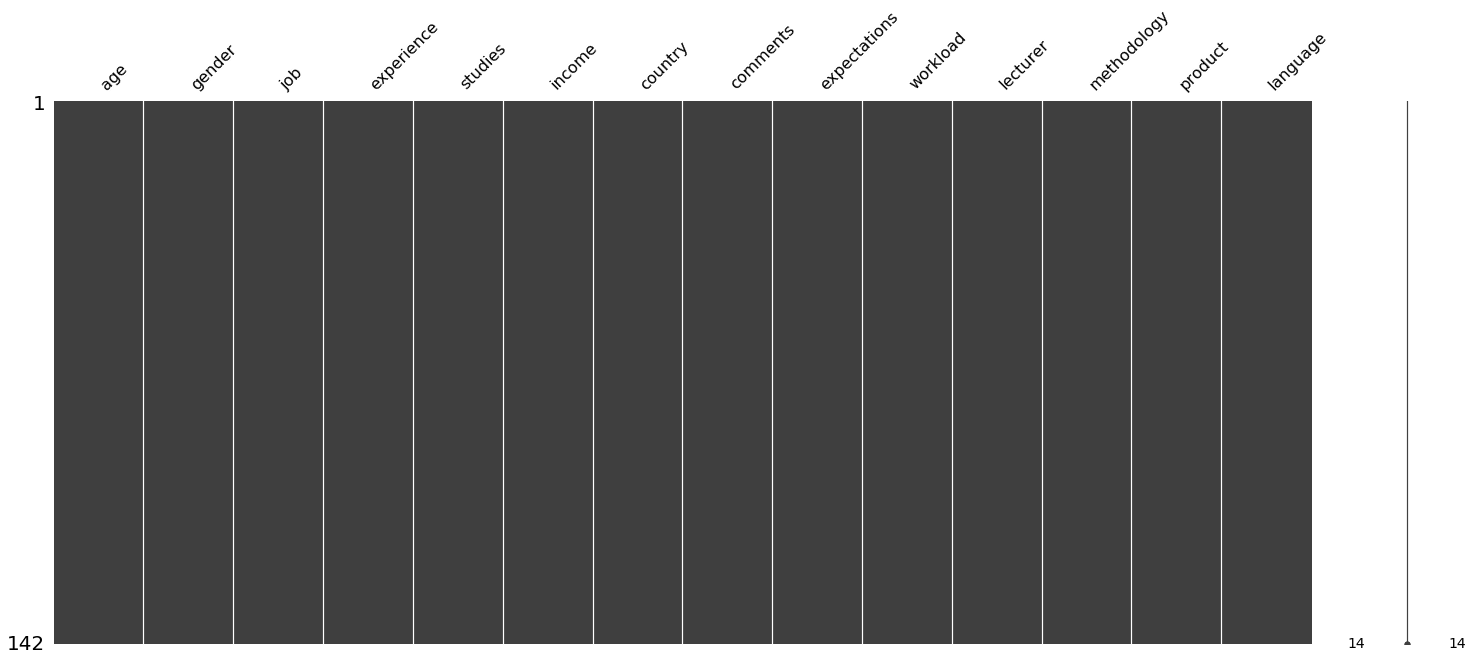

In [73]:
msno.matrix(en_data);

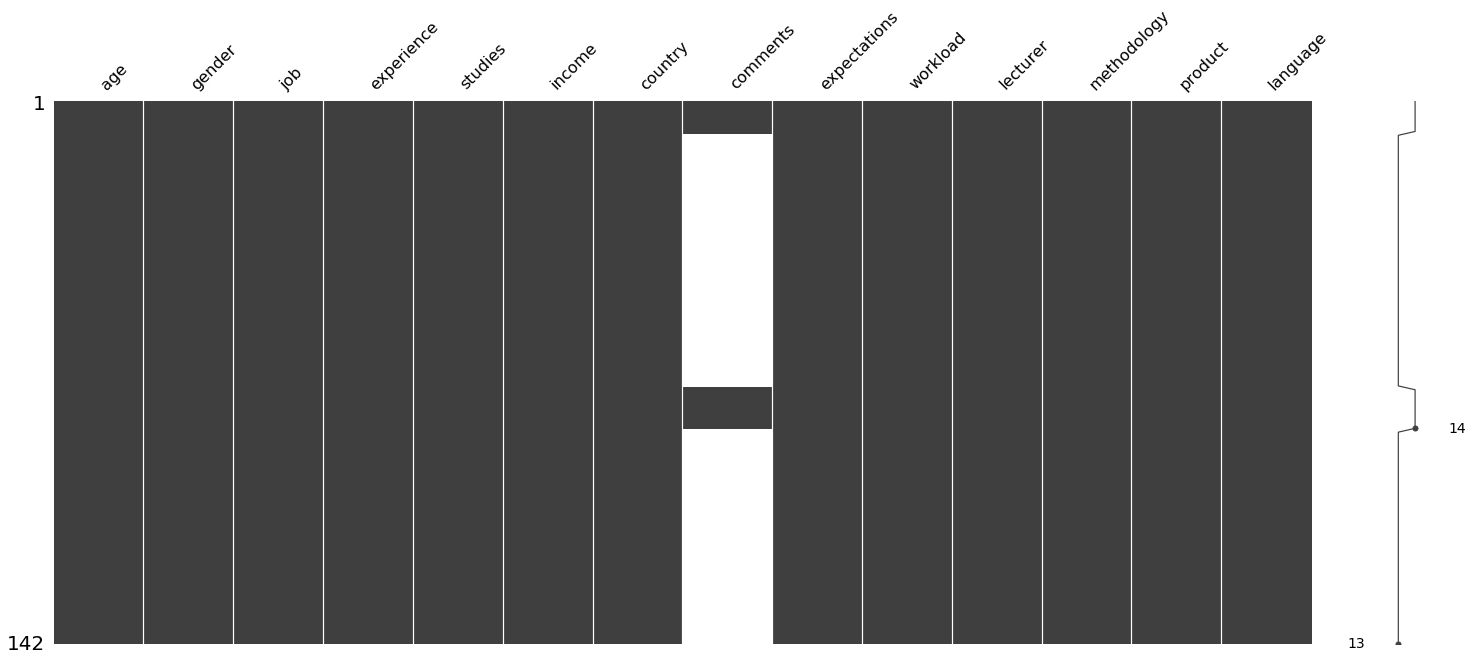

In [74]:
msno.matrix(es_data);

In [75]:
en_counter = 0
for row in en_data["comments"]:
    if type(row)!=float:
        en_counter +=1
print("Total percentage of comments in English Satisfaction Surveys: ", round(en_counter/len(en_data["comments"])*100, 2), "%")


es_counter = 0
for row in es_data["comments"]:
    if type(row)!=float:
        es_counter +=1
print("Total percentage of comments in Spanish Satisfaction Surveys: ", round(es_counter/len(es_data["comments"])*100, 2), "%")




Total percentage of comments in English Satisfaction Surveys:  100.0 %
Total percentage of comments in Spanish Satisfaction Surveys:  14.08 %


### Data Cleaning

In [81]:
for i, comm in enumerate(en_data["comments"]):
    if type(en_data["comments"][i]) != float:
        en_data["comments"][i] = clean_en_text(comm)

en_data["comments"]

0        hi know coming guys looks recent found way make
1      martin ostler gym pastures united kingdom wed sep
2      full immersion combine ft job learning eves we...
3      sam cater kicks bootcamp providing personal in...
4                    complete go zero hero become expert
                             ...                        
137                     school finally excitement agenda
138    day progress made almost finished intermediate...
139      hi know coming guys looks recent found way make
140    complete sql bootcamp php python udemy coupon ...
141                                           check free
Name: comments, Length: 142, dtype: object

In [82]:
for i, comm in enumerate(es_data["comments"]):
    if type(es_data["comments"][i]) != float:
        es_data["comments"][i] = clean_es_text(comm)

es_data["comments"]

0              siguiente edición fullstack web esperamos
1                         dale lleva botella agua toalla
2      dicho muchisima gente capa campo dando mentori...
3      mira siendote sincera favor ningun creo despro...
4      acerca global microsoft developer bootcamp voi...
                             ...                        
137                                                  NaN
138                                                  NaN
139                                                  NaN
140                                                  NaN
141                                                  NaN
Name: comments, Length: 142, dtype: object

### 💚 Sentiment analysis by language

#### VADER_EN

In [83]:
#Checking what it is inside index4:
en_data["comments"][4]

'complete go zero hero become expert'

In [84]:
VADER_sent_en = sentiment_classifier(en_data["comments"])

In [85]:
for comment in en_data["comments"]:
    sentiment_analyzer_scores(comment)

hi know coming guys looks recent found way make {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
martin ostler gym pastures united kingdom wed sep {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.4215}
full immersion combine ft job learning eves weekends process {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sam cater kicks bootcamp providing personal insights stressing importance {'neg': 0.208, 'neu': 0.583, 'pos': 0.208, 'compound': 0.0}
complete go zero hero become expert----- {'neg': 0.0, 'neu': 0.581, 'pos': 0.419, 'compound': 0.5574}
thanks inviting us virtual event wait start working {'neg': 0.0, 'neu': 0.536, 'pos': 0.464, 'compound': 0.6369}
microsoft education code inclusive physical coding {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
arrested edd calls web unemployment fraud read {'neg': 0.71, 'neu': 0.29, 'pos': 0.0, 'compound': -0.8689}
voices participation aspects society important {'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.2023}
delig

In [86]:
en_data["sentiment"] = VADER_sent_en
en_data.head(3)

,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language,sentiment
0,66,M,economics,9,master,26961,CO,hi know coming guys looks recent found way make,3,4,0,2,A,0,2
1,41,M,consultant,9,master,38792,UK,martin ostler gym pastures united kingdom wed sep,1,5,4,0,A,0,1
2,47,F,business administration,0,master,59526,BR,full immersion combine ft job learning eves we...,4,3,3,3,A,0,2


#### SENTY_ES

In [87]:
SENTY_sent_es = senty_classifier_es(es_data["comments"])

In [88]:
es_data["sentiment"] = SENTY_sent_es.copy()
es_data["sentiment"].value_counts()

2    124
0     16
1      2
Name: sentiment, dtype: int64

### 🧡 Sentiment analysis by product

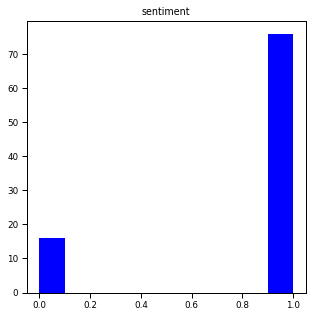

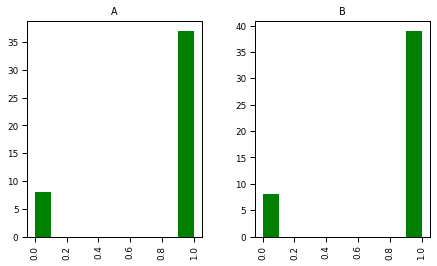

In [89]:
# Applying filter function to keep only positive and negative comments, avoid neutral.

df_en = en_data[en_data['sentiment'] != 2]
df_en.hist(column="sentiment", grid=False, color='blue', figsize=(5,5));

df_en["sentiment"].hist(by=df_en["product"], grid=False, color='green', figsize=(7,4));

In [90]:
print(df_en["sentiment"].value_counts())
print(df_en["sentiment"].value_counts().sum())

print("Total percentage of positive comments: ", (round(df_en["sentiment"].value_counts()[1]/(df_en["sentiment"].value_counts().sum())*100, 2)), "%")

1    76
0    16
Name: sentiment, dtype: int64
92
Total percentage of positive comments:  82.61 %


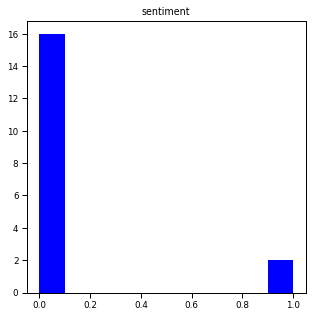

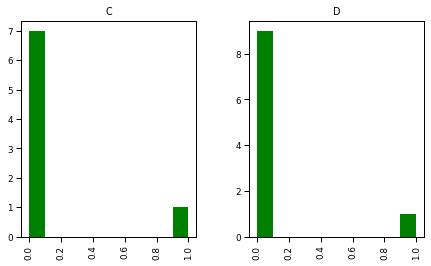

In [91]:
# Applying same filter function as above.

df_es = es_data[es_data['sentiment'] != 2]
df_es.hist(column="sentiment", grid=False, color='blue', figsize=(5,5));

df_es["sentiment"].hist(by=df_es["product"], grid=False, color='green', figsize=(7,4));

## 🗺️ Merging with demographic data

In [92]:
frames = [en_data, es_data]

In [93]:
merged = pd.concat(frames, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [94]:
merged.shape

(284, 15)

In [95]:
merged.head(3)

,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language,sentiment
0,66,M,economics,9,master,26961,CO,hi know coming guys looks recent found way make,3,4,0,2,A,0,2
1,41,M,consultant,9,master,38792,UK,martin ostler gym pastures united kingdom wed sep,1,5,4,0,A,0,1
2,47,F,business administration,0,master,59526,BR,full immersion combine ft job learning eves we...,4,3,3,3,A,0,2


## Feature engineering

In [96]:
data = merged.copy()
data = data.reset_index(drop=True) 


In [97]:
data.head(2)

,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language,sentiment
0,66,M,economics,9,master,26961,CO,hi know coming guys looks recent found way make,3,4,0,2,A,0,2
1,41,M,consultant,9,master,38792,UK,martin ostler gym pastures united kingdom wed sep,1,5,4,0,A,0,1


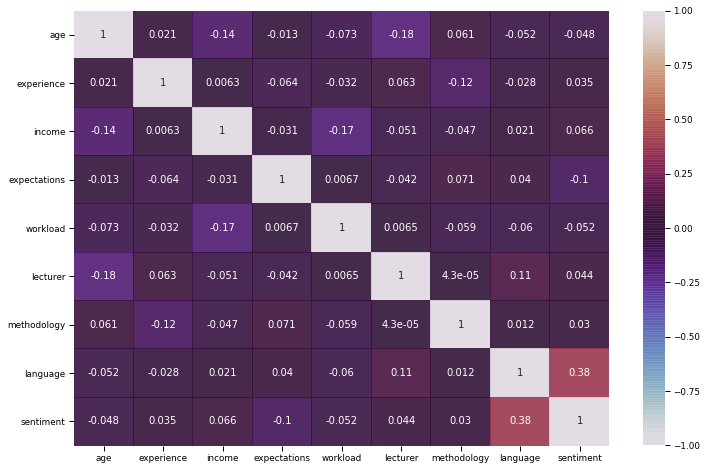

In [98]:
# Let's find the correlations:

plt.figure(figsize=(12,8))
data_corr = data.corr()
sns.heatmap(data_corr, annot = True, vmax=1, vmin=-1, center=0, cmap="twilight", alpha=0.9)
plt.show()

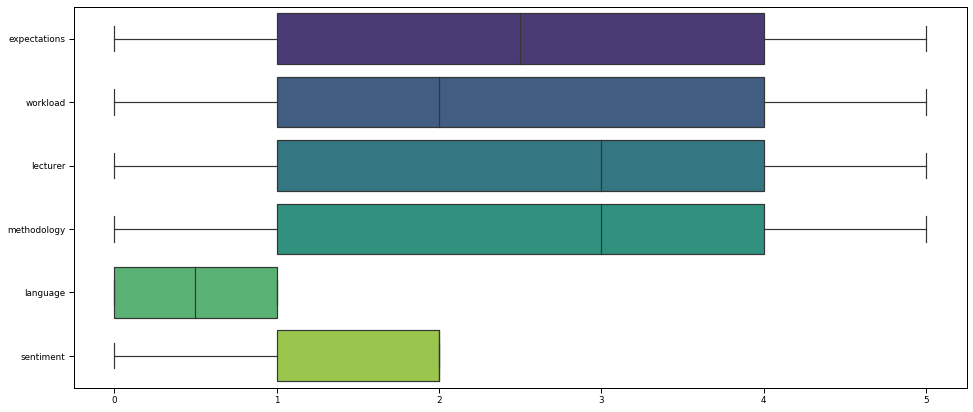

In [99]:
plt.figure(figsize=(16,7))
num_data = data.iloc[:, 8:16]
num_data
sns.boxplot(data=num_data , orient="h", palette="viridis");


## ♻️ Converting categorical features

In [100]:
# CHECKPOINT:
categorical_data = data.copy()


In [101]:
categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           284 non-null    int64 
 1   gender        284 non-null    object
 2   job           284 non-null    object
 3   experience    284 non-null    int64 
 4   studies       284 non-null    object
 5   income        284 non-null    int64 
 6   country       284 non-null    object
 7   comments      162 non-null    object
 8   expectations  284 non-null    int64 
 9   workload      284 non-null    int64 
 10  lecturer      284 non-null    int64 
 11  methodology   284 non-null    int64 
 12  product       284 non-null    object
 13  language      284 non-null    int64 
 14  sentiment     284 non-null    int64 
dtypes: int64(9), object(6)
memory usage: 33.4+ KB


In [102]:
categorical_data = categorical_data.drop(["comments"], axis=1)
categorical_data.columns

Index(['age', 'gender', 'job', 'experience', 'studies', 'income', 'country',
       'expectations', 'workload', 'lecturer', 'methodology', 'product',
       'language', 'sentiment'],
      dtype='object')

In [103]:
# Categorical boolean mask:
categorical_feature_mask = categorical_data.dtypes==object

# Filter categorical columns using mask and turn it into a list
categorical_cols = categorical_data.columns[categorical_feature_mask].tolist()

In [104]:
range_length = 10

def create_age_range(x, y):
    age_ranges = [i for i in range(x, y, range_length)]
    return age_ranges

age_range = create_age_range(25,76)


In [105]:
def age_string_parser(ages):
    """
    'ages' must be a list.
    """
    for ind, row in enumerate(ages):
        if row <= age_range[0]:
            ages[ind] = "< {}".format(age_range[0])
        elif row > age_range[0] and row <= age_range[1]:
            ages[ind] = "{}-{}".format(age_range[0], age_range[1])
        elif row > age_range[1] and row <= age_range[2]:
            ages[ind] = "{}-{}".format(age_range[1], age_range[2])
        elif row > age_range[2] and row <= age_range[3]:
            ages[ind] = "{}-{}".format(age_range[2], age_range[3])
        elif row > age_range[3] and row <= age_range[4]:
            ages[ind] = "{}-{}".format(age_range[3], age_range[4])
        elif row > age_range[4] and row <= age_range[5]:
            ages[ind] = "{}-{}".format(age_range[4], age_range[5])
        elif row > age_range[5]:
            ages[ind] = "> {}".format(age_range[5])


In [106]:
age_string_parser(categorical_data["age"])

In [107]:
print(categorical_data["age"])

0      65-75
1      35-45
2      45-55
3      35-45
4      65-75
       ...  
279    45-55
280    25-35
281     < 25
282    45-55
283    65-75
Name: age, Length: 284, dtype: object


In [108]:
le = LabelEncoder()

# Applying Label Encoder

categorical_data[categorical_cols] = categorical_data[categorical_cols].apply(lambda col: le.fit_transform(col))
categorical_data[categorical_cols].head(5)

,gender,job,studies,country,product
0,1,3,2,1,0
1,1,2,2,6,0
2,0,0,2,0,0
3,1,10,0,5,0
4,0,7,2,1,0


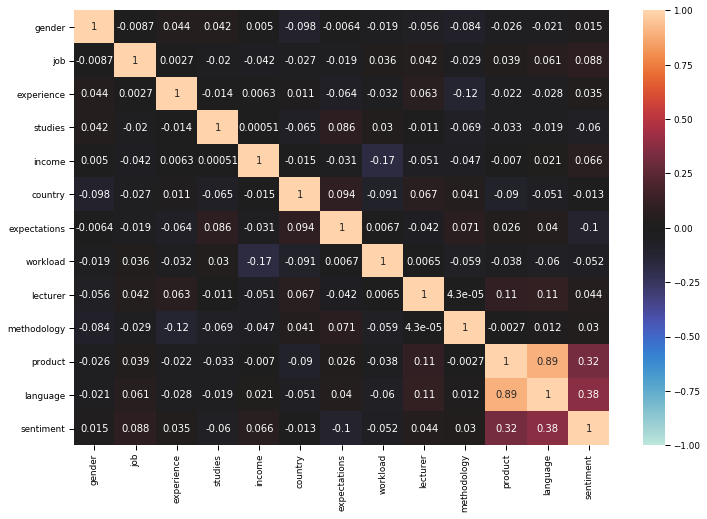

In [109]:
# Correlation matrix with categorical data:

plt.figure(figsize=(12,8))
data_corr2 = categorical_data.corr()
sns.heatmap(data_corr2, annot=True, vmax=1, vmin=-1, center=0)
plt.show()

### 💖  Complete Sentiment Analysis | VADER 💖

#### Exploring **Expectations**:

In [114]:
data.head(2)

,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language,sentiment
0,66,M,economics,9,master,26961,CO,hi know coming guys looks recent found way make,3,4,0,2,A,0,2
1,41,M,consultant,9,master,38792,UK,martin ostler gym pastures united kingdom wed sep,1,5,4,0,A,0,1


In [115]:
lang_grouped_frames = data.groupby("language")
lang_grouped_frames.mean()

,age,experience,income,expectations,workload,lecturer,methodology,sentiment
language,,,,,,,,
0,50.204225,4.908451,44373.549296,2.408451,2.471831,2.429577,2.492958,1.239437
1,48.535211,4.746479,45106.542254,2.549296,2.267606,2.802817,2.535211,1.760563


We can observe that the average expectations are slightly more fulfilled in products offered in language 1 than in language 0.

In [116]:
prod_grouped_frames = data.groupby("product")
prod_grouped_frames.mean()

,age,experience,income,expectations,workload,lecturer,methodology,language,sentiment
product,,,,,,,,,
A,48.614286,4.985714,44352.614286,2.271429,2.414286,2.685714,2.471429,0.0,1.242857
B,51.750000,4.833333,44393.902778,2.541667,2.527778,2.180556,2.513889,0.0,1.236111
C,50.053333,4.640000,47002.013333,2.746667,2.213333,2.520000,2.653333,1.0,1.800000
D,46.835821,4.865672,42984.746269,2.328358,2.328358,3.119403,2.402985,1.0,1.716418


Curiously, the average income of the customers buying product C is a little above than the rest.
In general, the mean satisfaction related to their expectations and methodology is also over the other products.

### Is the gender of our costumers related to the satisfaction of our products?

In [117]:
gender_grouped_frames = data.groupby("gender")
gender_grouped_frames.mean()

,age,experience,income,expectations,workload,lecturer,methodology,language,sentiment
gender,,,,,,,,,
F,48.646259,4.707483,44655.918367,2.489796,2.401361,2.707483,2.653061,0.510204,1.489796
M,50.145985,4.956204,44830.313869,2.467153,2.335766,2.518248,2.364964,0.489051,1.510949


WoW!! This is quite tricky!
Whereas F costumers apparently feel a little bit more satisfied with products in all areas (expectations, workload, lecturers and methodology) than M costumers, F comments seem to be less positive than those from M.

In [118]:
data.groupby(['gender', 'product'],as_index=False)['expectations'].mean()

,gender,product,expectations
0,F,A,2.514286
1,F,B,2.486486
2,F,C,2.589744
3,F,D,2.361111
4,M,A,2.028571
5,M,B,2.600000
6,M,C,2.916667
7,M,D,2.290323


Nevertheless, if we go deeper in our exploration, it is clear that our Spanish products are preferred by women whereas our English products are preferred by men instead.

### Level of Satisfaction by Age

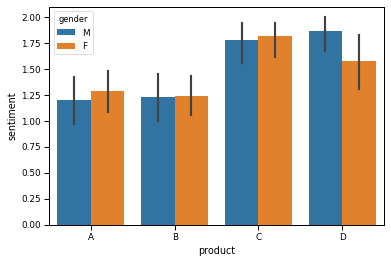

In [119]:
ax0 = sns.barplot(x="product", y="sentiment", hue="gender", data=data)


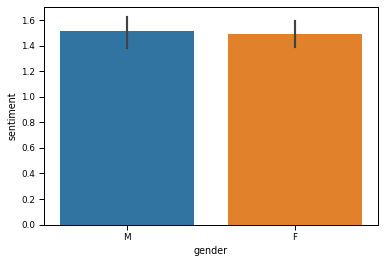

In [120]:
ax1 = sns.barplot(x="gender",y="sentiment", data= data, order=["M", "F"])

In [121]:
#ax2 = sns.barplot(x="age",y="expectations", hue="product", data= data)
data[["product", "age", "expectations"]]

,product,age,expectations
0,A,66,3
1,A,41,1
2,A,47,4
3,A,38,4
4,A,71,4
...,...,...,...
279,D,51,2
280,D,27,5
281,D,24,5
282,D,54,5


### Level of Satisfaction by Studies

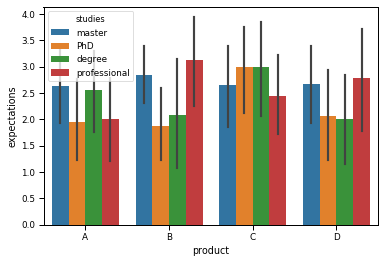

In [122]:
sns.set_context('paper')
ax3 = sns.barplot(x="product",y="expectations", hue="studies", data= data)

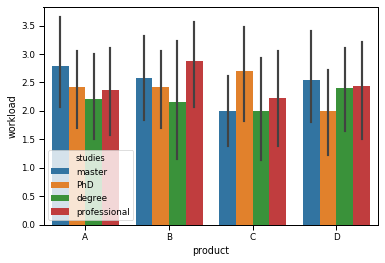

In [123]:
ax4 = sns.barplot(x="product",y="workload", hue="studies", data= data)

In [124]:
data[data["job"]=="informatics engineer"].head()
# Missing comments are considered "neutral", so we will filter our dataframe and keep only positive and negative comments.

,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language,sentiment
47,56,M,informatics engineer,3,degree,56678,CO,day tasks bootcamp video hours problem solving...,4,0,1,4,A,0,0
118,52,F,informatics engineer,2,degree,45937,FR,depending bootcamp may seen,2,1,0,3,B,0,2
153,71,M,informatics engineer,9,master,33506,UK,NaN,2,1,3,4,C,1,2
154,73,M,informatics engineer,4,master,75596,US,NaN,5,1,2,1,C,1,2
164,57,F,informatics engineer,4,PhD,23230,BR,NaN,4,5,5,0,C,1,2


In [125]:
data_sent = data[data['sentiment'] != 2]
data_sent.shape

(110, 15)

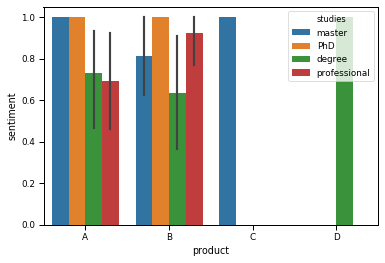

In [126]:
ax5 = sns.barplot(x="product",y="sentiment", hue="studies", data= data_sent)

Definitely, A and B products cause more sentiment variability among our students, regardless of their academic level. It is true that students from professional background give more positive comments for product B than for product A, compared to the students with the rest of academic levels. Also, product A is the most successful among students with higher level of education, whereas product C seems to be specially addressed to students with master level and prouduct D to students with degree level.")
print("At this point here we should check, for the products with missing comments from some of the academic levels, if there are actually people from those academic levels enrolled in.

In [127]:
data_sent.groupby(["product", "studies"])["sentiment"].value_counts()

product  studies       sentiment
A        PhD           1            10
         degree        1            11
                       0             4
         master        1             7
         professional  1             9
                       0             4
B        PhD           1             7
         degree        1             7
                       0             4
         master        1            13
                       0             3
         professional  1            12
                       0             1
C        PhD           0             4
         degree        0             1
         master        1             1
         professional  0             2
D        PhD           0             2
         degree        1             1
         master        0             5
         professional  0             2
Name: sentiment, dtype: int64

After the check we can conclude that the missing bars from the other academic backgorunds in products C and D are not actually missing but '0' sentiment assigned which means 'negative comments'.

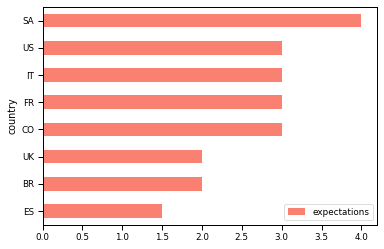

In [128]:
expect_country = data_sent[["country", "expectations"]]
expect_country.groupby(['country']).median().sort_values("expectations").plot.barh(color="salmon");

Saudi Arabia is the country where our costumers have their expectations more fulfilled.

In [129]:
#data.to_csv('data_for_topic_modeling.csv')